In [97]:
%pip install git+https://github.com/yfukai/BaSiCPy@metric_udpate
#%pip install -q plotly==5.4.0

  Cloning https://github.com/yfukai/BaSiCPy (to revision metric_udpate) to /tmp/pip-req-build-_n6yoq5y
  Running command git clone --filter=blob:none --quiet https://github.com/yfukai/BaSiCPy /tmp/pip-req-build-_n6yoq5y
  Running command git checkout -b metric_udpate --track origin/metric_udpate
  Switched to a new branch 'metric_udpate'
  Branch 'metric_udpate' set up to track remote branch 'metric_udpate' from 'origin'.
  Resolved https://github.com/yfukai/BaSiCPy to commit dd645818a6c3bfcefd2cf071e13e7fb69d73109f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [2]:
import numpy as np
from os import path

# from aicsimageio import AICSImage
# from aicspylibczi import CziFile
from tqdm import tqdm
from itertools import product
from matplotlib import pyplot as plt
from skimage.io import imread
import pandas as pd
import yaml
from skimage import filters

# from cucim.skimage.morphology import binary_erosion, disk
from basicpy import BaSiC
from basicpy.metrics import autotune_cost, entropy, fourier_L0_norm

In [3]:
import glob

# file_path = "/content/drive/MyDrive/Colab Notebooks/BaSiCPy-dev/Simulation/simulatedimages/"
file_path = "./"

nuc_channel_idx = 2
cyto_channel_idx = 0

In [4]:
import jax

jax.config.update("jax_platform_name", "gpu")
jax.config.update("jax_default_device", jax.devices()[2])

In [5]:
flatfield_true = np.load(path.join(file_path, f"flatfield_true.npy"))

In [6]:
weights = imread(path.join(file_path, "weights.tif"))

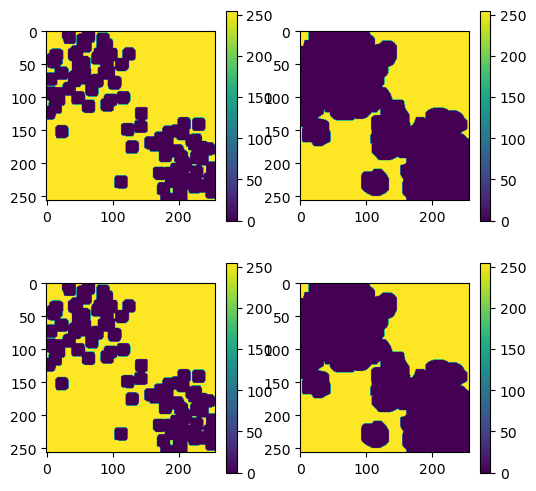

In [7]:
plt.figure(figsize=(6, 6))
plt.subplot(221)
plt.imshow(weights[nuc_channel_idx, 100])
plt.colorbar()
plt.subplot(222)
plt.imshow(weights[cyto_channel_idx, 100])
plt.colorbar()
plt.subplot(223)
plt.imshow(weights[nuc_channel_idx, 100])
plt.colorbar()
plt.subplot(224)
plt.imshow(weights[cyto_channel_idx, 100])
plt.colorbar()

In [8]:
darkfield_true = np.load(path.join(file_path, f"darkfield_true.npy"))
baseline_true = np.load(path.join(file_path, f"baseline_true.npy"))

In [9]:
images_distorted_wo_darkfield = imread(path.join(file_path, "wo_darkfield2.tif"))
images_distorted_w_darkfield = imread(path.join(file_path, "w_darkfield2.tif"))

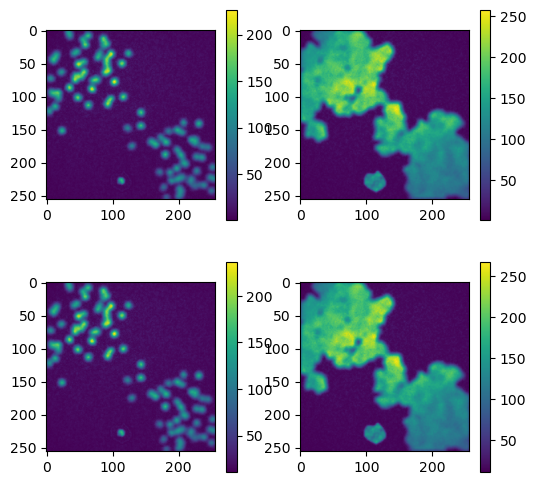

In [10]:
plt.figure(figsize=(6, 6))
plt.subplot(221)
plt.imshow(images_distorted_wo_darkfield[nuc_channel_idx, 100])
plt.colorbar()
plt.subplot(222)
plt.imshow(images_distorted_wo_darkfield[cyto_channel_idx, 100])
plt.colorbar()
plt.subplot(223)
plt.imshow(images_distorted_w_darkfield[nuc_channel_idx, 100])
plt.colorbar()
plt.subplot(224)
plt.imshow(images_distorted_w_darkfield[cyto_channel_idx, 100])
plt.colorbar()

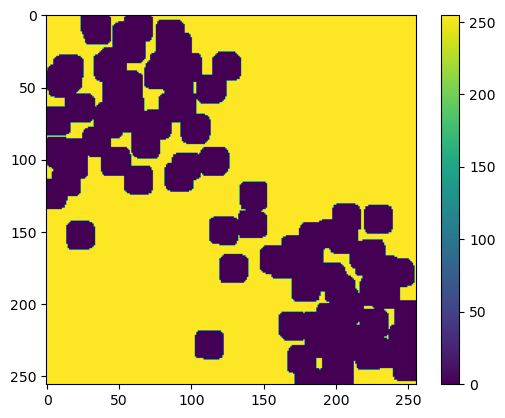

In [11]:
plt.imshow(weights[nuc_channel_idx, 100])
plt.colorbar()

In [12]:
def add_noise(im):
    if im.ndim > 2:
        return np.array(
            [
                filters.gaussian(np.random.poisson(_im), sigma=1, preserve_range=True)
                for _im in im
            ]
        )
    else:
        return filters.gaussian(np.random.poisson(im), sigma=1, preserve_range=True)

In [13]:
images_distorted_wo_darkfield_with_noise = []
for channel_index in [nuc_channel_idx, cyto_channel_idx][:]:
    im = images_distorted_wo_darkfield[channel_index]
    im = add_noise(im)
    images_distorted_wo_darkfield_with_noise.append(im)
np.save(
    "images_distorted_wo_darkfield_with_noise.npy",
    images_distorted_wo_darkfield_with_noise,
)

In [14]:
histogram_qmin: float = 0.01
histogram_qmax: float = 0.99
vmin_factor: float = 0.6
vrange_factor: float = 1.5
histogram_bins: int = 1000
histogram_use_fitting_weight: bool = True
fourier_l0_norm_image_threshold: float = 0.1
fourier_l0_norm_fourier_radius = 10
fourier_l0_norm_threshold = 1e-3
fourier_l0_norm_cost_coef = 1e4

In [15]:
import warnings

warnings.simplefilter("ignore", DeprecationWarning)

  0%|                                                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

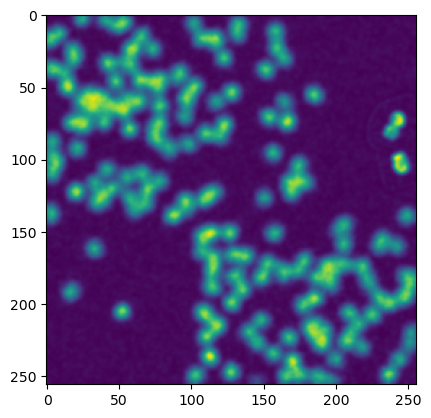

 25%|█████████████████████████████████████████████▊                                                                                                                                         | 1/4 [00:21<01:05, 21.94s/it]WARNING:basicpy.basicpy:Reweighting did not converge.


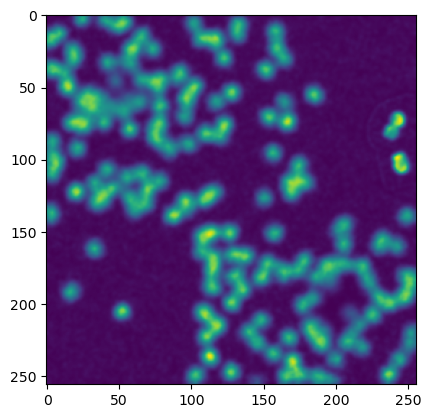

 50%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 2/4 [00:25<00:21, 10.96s/it]

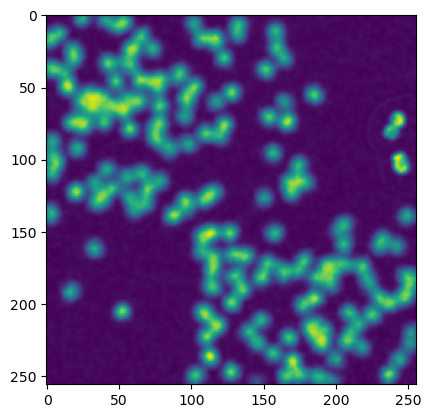

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 3/4 [00:47<00:15, 15.99s/it]

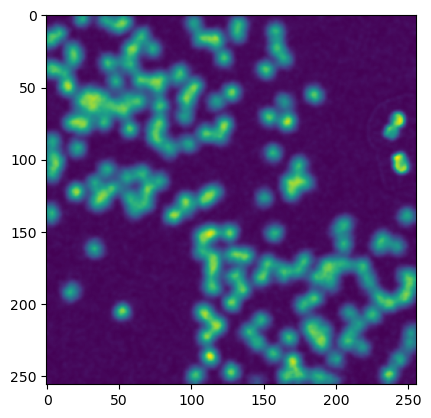

  0%|                                                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

In [ ]:
conds0 = list(
    product(
        ["ladmap", "approximate"],  # fitting_mode
        [False],
        [True, False],
    )
)
conds = list(
    product(
        list(np.logspace(-3, 2, 15)),
        ["ladmap", "approximate"],  # fitting_mode
        [False],
        [True, False],
        list(range(5)),
    )
)
parameters = []
for channel_index in [nuc_channel_idx, cyto_channel_idx][:]:
    for fitting_mode, sort_intensity, use_weight in tqdm(conds0):
        np.random.seed(1135 + channel_index * 50000)
        p = {
            "smoothness_flatfield": 0.05,
            "fitting_mode": fitting_mode,
            "sort_intensity": sort_intensity,
        }
        p2 = p.copy()
        p2.update(
            {
                "channel_index": channel_index,
                "use_weight": use_weight,
            }
        )
        b = BaSiC(**p, get_darkfield=False)
        im = images_distorted_wo_darkfield[channel_index]
        im = add_noise(im)
        w = weights[channel_index] if use_weight else None

        b.fit(im, fitting_weight=w)
        transformed_image = b.transform(im, timelapse=True)
        plt.imshow(transformed_image[-1])
        plt.show()
        vmin, vmax = np.quantile(transformed_image, [histogram_qmin, histogram_qmax])
        entropy_vmin = vmin_factor * vmin
        val_range = (vmax - vmin * vmin_factor) * vrange_factor
        p2["val_range"] = val_range
        parameters.append(p2)

val_ranges_df = pd.DataFrame.from_records(parameters).set_index(
    ["channel_index", "fitting_mode", "sort_intensity", "use_weight"]
)
val_ranges_df.to_csv(path.join(file_path, f"wo_darkfield_val_ranges.csv"))

In [ ]:
for channel_index in [nuc_channel_idx, cyto_channel_idx][:]:
    parameters = []
    flatfields = []
    baselines = []
    for smoothness_flatfield, fitting_mode, sort_intensity, use_weight, rep in tqdm(
        conds
    ):
        val_range = val_ranges_df.loc[
            (channel_index, fitting_mode, sort_intensity, use_weight), "val_range"
        ]
        np.random.seed(1135 + channel_index * 50000 + rep)
        p = {
            "smoothness_flatfield": smoothness_flatfield,
            "fitting_mode": fitting_mode,
            "sort_intensity": sort_intensity,
        }
        p2 = p.copy()
        p2.update(
            {"channel_index": channel_index, "use_weight": use_weight, "rep": rep}
        )
        b = BaSiC(**p, get_darkfield=False)
        im = images_distorted_wo_darkfield[channel_index]
        im = add_noise(im)
        w = weights[channel_index] if use_weight else None

        try:
            b.fit(im, fitting_weight=w)
            flatfields.append(b.flatfield)
            baselines.append(b.baseline)

            transformed_image = b.transform(im, timelapse=True)
            vmin, vmax = np.quantile(
                transformed_image, [histogram_qmin, histogram_qmax]
            )
            entropy_vmin = vmin_factor * vmin
            entropy_vmax = entropy_vmin + val_range
            p2["entropy"] = entropy(
                transformed_image,
                vmin=entropy_vmin,
                vmax=entropy_vmax,
                bins=histogram_bins,
                weights=w,
                clip=True,
            )
            p2["fourier_L0_norm"] = fourier_L0_norm(
                b.flatfield,
                fourier_l0_norm_image_threshold,
                fourier_l0_norm_fourier_radius,
            )
            p2["autotune_cost"] = autotune_cost(
                transformed_image,
                b.flatfield,
                weights=w,
                entropy_vmin=entropy_vmin,
                entropy_vmax=entropy_vmax,
                histogram_bins=histogram_bins,
                fourier_l0_norm_cost_coef=fourier_l0_norm_cost_coef,
                fourier_l0_norm_image_threshold=fourier_l0_norm_image_threshold,
                fourier_l0_norm_fourier_radius=fourier_l0_norm_fourier_radius,
                fourier_l0_norm_threshold=fourier_l0_norm_threshold,
            )
        except RuntimeError:
            flatfields.append(np.ones_like(b.flatfield) * np.nan)
            baselines.append(np.ones_like(b.baseline) * np.nan)
            p2["autotune_cost"] = np.nan
        finally:
            parameters.append(p2)
    shape = [f.shape for f in flatfields][0]
    flatfields2 = [
        np.array(f) if f.shape == shape else np.ones(shape) * np.nan for f in flatfields
    ]
    shape = baselines[0].shape
    baselines2 = [
        np.array(b)
        if hasattr(b, "shape") and b.shape == shape
        else np.ones(shape) * np.nan
        for b in baselines
    ]
    np.save(
        path.join(file_path, f"wo_darkfield_flatfields_channel_{channel_index}_2.npy"),
        flatfields2,
    )
    np.save(
        path.join(file_path, f"wo_darkfield_baselines_channel_{channel_index}_2.npy"),
        baselines2,
    )
    assert len(flatfields2) == len(parameters)
    parameters_df = pd.DataFrame.from_records(parameters)
    parameters_df.to_csv(
        path.join(file_path, f"wo_darkfield_parameters_channel_{channel_index}_2.csv")
    )

In [ ]:
plt.imshow(flatfield_true)

In [ ]:
from scipy.fft import dctn

SF = dctn(flatfield_true)
plt.imshow(SF, vmin=-1, vmax=1)
plt.colorbar()

In [ ]:
parameters_df = pd.read_csv(
        path.join(file_path, f"wo_darkfield_parameters_channel_0_2.csv")
    )
flatfields = np.load(
    path.join(file_path, f"wo_darkfield_flatfields_channel_0_2.npy"),
)
baselines = np.load(
    path.join(file_path, f"wo_darkfield_baselines_channel_0_2.npy"),
)
ii=200
row = parameters_df.iloc[ii]
row

In [ ]:
plt.figure(figsize=(6,4))
plt.subplot(231)
plt.imshow(flatfield_true,vmax=1.4,vmin=0.4)
plt.colorbar()
plt.subplot(232)
plt.imshow(flatfields[ii],vmax=1.4,vmin=0.4)
plt.colorbar()
plt.subplot(233)
plt.imshow(flatfield_true/flatfields[ii])
plt.colorbar()
plt.subplot(234)
plt.plot(baseline_true)
plt.plot(baselines[ii])
plt.tight_layout()

In [ ]:
gt_values = {}

for channel_index in [nuc_channel_idx, cyto_channel_idx]:
    im_orig = images_distorted_wo_darkfield[channel_index]
    w = weights[channel_index] if row["use_weight"] else np.ones_like(im_orig)
    im = add_noise(im_orig)
    plt.subplot(161)
    plt.imshow(im[0])
    plt.subplot(162)
    plt.imshow(im_orig[0])
    
    for jj, (ft, bt) in enumerate([
        (flatfield_true,baseline_true),
        (flatfields[ii],baselines[ii])
    ]):
        b.flatfield = ft
        b.baseline = bt
        b.darkfield = np.zeros_like(flatfield_true)
        transformed_image = b.transform(im, timelapse=True)
        transformed_image2 = b.transform(im_orig, timelapse=True)
        vmin, vmax = np.quantile(
            transformed_image, [histogram_qmin, histogram_qmax]
        )
        entropy_vmin = vmin_factor * vmin
        entropy_vmax = entropy_vmin + val_range

        v={}
        v["entropy"] = float(entropy(
                        transformed_image,
                        vmin=entropy_vmin,
                        vmax=entropy_vmax,
                        bins=histogram_bins,
                        weights=w,
                        clip=True,
                    ))
        v["fourier_L0_norm"] = float(fourier_L0_norm(
                        b.flatfield,
                        fourier_l0_norm_image_threshold,
                        fourier_l0_norm_fourier_radius,
                    ))
        v["autotune_cost"] = float(autotune_cost(
                        transformed_image,
                        b.flatfield,
                        entropy_vmin=entropy_vmin,
                        entropy_vmax=entropy_vmax,
                        histogram_bins=histogram_bins,
                        fourier_l0_norm_cost_coef=fourier_l0_norm_cost_coef,
                        fourier_l0_norm_image_threshold=fourier_l0_norm_image_threshold,
                        fourier_l0_norm_fourier_radius=fourier_l0_norm_fourier_radius,
                        fourier_l0_norm_threshold=fourier_l0_norm_threshold,
                    ))
        plt.subplot(1,6,3+jj*2)
        plt.imshow(transformed_image[0])
        plt.subplot(1,6,4+jj*2)
        plt.imshow(transformed_image2[0])
        gt_values[str(channel_index)+"_"+("true" if jj==0 else "reference")] = v
    plt.show()
print(gt_values)
with open("wo_darkfield_ground_truth_values.yaml", "w") as f:
    yaml.dump(gt_values, f)

In [ ]:
parameters_df

In [ ]:
conds0 = list(
    product(
        ["ladmap", "approximate"],  # fitting_mode
        [
            # True,
            False
        ],
        [True, False],
    )
)

conds = list(
    product(
        [
            nuc_channel_idx,
            cyto_channel_idx,
        ],
        list(np.logspace(-3, 2, 4)),
        list(np.logspace(-3, 2, 4)),
        list(np.logspace(-3, 2, 4)),
        list(range(5)),
    )
)
"""
conds = list(
    product(
        [
            nuc_channel_idx,
            cyto_channel_idx,
        ],
        list(np.logspace(-3, 2, 1)),
        list(np.logspace(-3, 2, 1)),
        list(np.logspace(-3, 2, 1)),
        list(range(1)),
    )
)
"""

np.random.seed(1136)
for fitting_mode, sort_intensity, use_weight in conds0[-1:]:
    parameters_d = []
    flatfields_d = []
    darkfields_d = []
    baselines_d = []
    label = f"{fitting_mode}_sort{sort_intensity}_weight{use_weight}"
    for (
        channel_index,
        smoothness_flatfield,
        smoothness_darkfield,
        sparse_cost_darkfield,
        rep,
    ) in tqdm(conds):
        p = {
            "smoothness_flatfield": smoothness_flatfield,
            "smoothness_darkfield": smoothness_darkfield,
            "sparse_cost_darkfield": sparse_cost_darkfield,
            "fitting_mode": fitting_mode,
            "sort_intensity": sort_intensity,
        }
        p2 = p.copy()
        p2.update(
            {"channel_index": channel_index, "use_weight": use_weight, "rep": rep}
        )
        im = images_distorted_w_darkfield[channel_index]
        im = add_noise(im)
        b = BaSiC(**p, get_darkfield=True)
        try:
            b.fit(im, fitting_weight=weights[channel_index] if use_weight else None)
            transformed_image = b.transform(im, timelapse=True)
            vmin, vmax = np.quantile(
                transformed_image, [histogram_qmin, histogram_qmax]
            )
            entropy_vmin = vmin_factor * vmin
            entropy_vmax = entropy_vmin + val_range
            p2["entropy"] = entropy(
                transformed_image,
                vmin=entropy_vmin,
                vmax=entropy_vmax,
                bins=histogram_bins,
                weights=w,
                clip=True,
            )
            p2["fourier_L0_norm"] = fourier_L0_norm(
                b.flatfield,
                fourier_l0_norm_image_threshold,
                fourier_l0_norm_fourier_radius,
            )
            p2["autotune_cost"] = autotune_cost(
                transformed_image,
                b.flatfield,
                entropy_vmin=entropy_vmin,
                entropy_vmax=entropy_vmax,
                histogram_bins=histogram_bins,
                fourier_l0_norm_cost_coef=fourier_l0_norm_cost_coef,
                fourier_l0_norm_image_threshold=fourier_l0_norm_image_threshold,
                fourier_l0_norm_fourier_radius=fourier_l0_norm_fourier_radius,
                fourier_l0_norm_threshold=fourier_l0_norm_threshold,
            )

            flatfields_d.append(b.flatfield)
            darkfields_d.append(b.darkfield)
            baselines_d.append(b.baseline)
        except (RuntimeError, AssertionError):
            flatfields_d.append(np.ones_like(b.flatfield) * np.nan)
            darkfields_d.append(np.ones_like(b.darkfield) * np.nan)
            baselines_d.append(np.ones_like(b.baseline) * np.nan)
        parameters_d.append(p2)

    shape = [f.shape for f in flatfields][0]
    flatfields2_d = [
        np.array(f) if f.shape == shape else np.ones(shape) * np.nan
        for f in flatfields_d
    ]
    darkfields2_d = [
        np.array(f) if f.shape == shape else np.ones(shape) * np.nan
        for f in darkfields_d
    ]
    shape = baselines[0].shape
    baselines2_d = [
        np.array(b)
        if hasattr(b, "shape") and b.shape == shape
        else np.ones(shape) * np.nan
        for b in baselines_d
    ]

    np.save(path.join(file_path, f"w_darkfield_flatfields_{label}.npy"), flatfields2_d)
    np.save(path.join(file_path, f"w_darkfield_darkfields_{label}.npy"), darkfields2_d)
    np.save(path.join(file_path, f"w_darkfield_baselines_{label}.npy"), baselines2_d)
    parameters_df = pd.DataFrame.from_records(parameters_d)
    parameters_df.to_csv(path.join(file_path, f"w_darkfield_parameters_{label}.csv"))

In [ ]:
parameters_df